In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import muon
import ott
import functools
import logging
import typing as t

import anndata as ad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import scanpy as sc
import scipy.sparse as sp
import scipy.stats as ss
from ott.geometry import costs, geometry, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from sklearn import metrics, model_selection
from ott.geometry import costs as sparse_costs

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['default', 'despine']


In [3]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [5]:
mudata = mudata[mudata.obs["cell_type"].isin(endocrine_celltypes)]

In [6]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1).astype("category")

/tmp/ipykernel_1269495/2312537565.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1).astype("category")


In [7]:
adata=mudata["rna"]


In [8]:
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obs["time"] = mudata.obs["time"] 

In [9]:
adata.X = adata.layers["raw_counts"]

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(adata, inplace=True, subset=True)

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [12]:
gex_early = adata[adata.obs["time"]==15.5].X.A
gex_late = adata[adata.obs["time"]==16.5].X.A

In [13]:
x=gex_early
y=gex_late

In [14]:
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, batch_size=1)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport

In [15]:
map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg=20.0))

In [16]:
from tqdm import tqdm
batch_size=100
push_forward = []
for i in tqdm(range(0, len(x), batch_size)):
    push_forward.append(map_l1(x[i:i+batch_size]))

100%|█████████████████████████████████████████████████████████████████████████████████████| 52/52 [1:16:52<00:00, 88.70s/it]


In [17]:
ls_flattened=[]
for el in push_forward:
    ls_flattened.extend(el)

In [18]:
res=np.asarray(ls_flattened)

In [19]:
gene_mask = (np.abs(res-x) > 1e-6)

In [20]:
adata_15 = adata[adata.obs["time"].isin((15.5, ))]

In [21]:
adata_15.layers["sparse_mask"] = gene_mask

/tmp/ipykernel_1269495/1174042063.py:1: ImplicitModificationWarning: Setting element `.layers['sparse_mask']` of view, initializing view as actual.
  adata_15.layers["sparse_mask"] = gene_mask


In [22]:
import os
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/sparse_monge"
adata_15.write(os.path.join(output_dir, "adata_15_with_sparse_mask_20_scaling.h5ad"))

In [23]:
adata_15.var["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=0)
adata_15.obs["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=1)

In [24]:
adata_15.var["sparse_counts"].sort_values()[-5:]/len(adata_15)

Mdk         0.152960
Pnliprp1    0.428404
Ctrb1       0.478023
Iapp        0.493846
Ins1        0.692127
Name: sparse_counts, dtype: float64

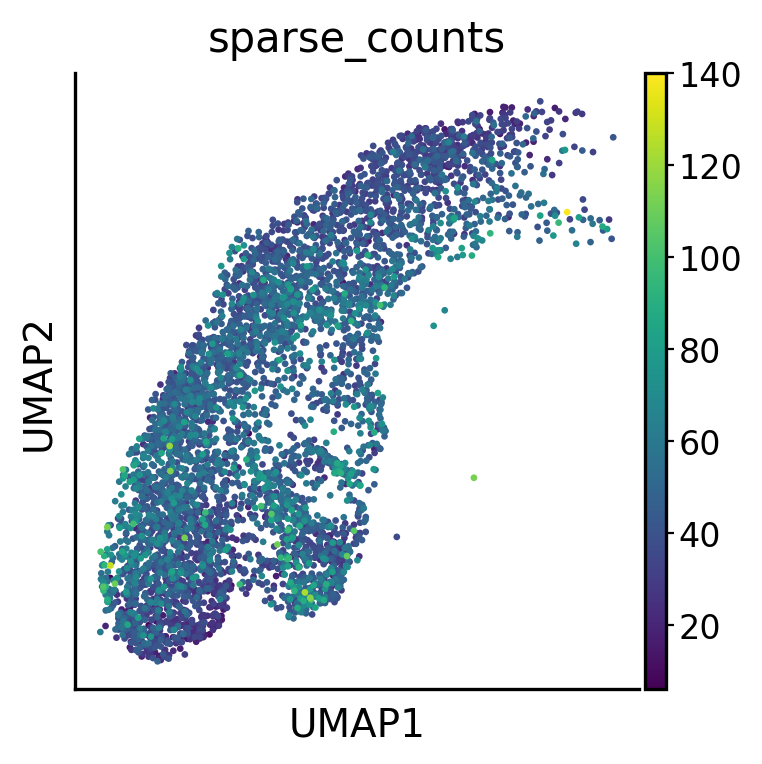

In [25]:
sc.pl.umap(adata_15, color='sparse_counts')

In [26]:
res_dict = {}
res_dict_2 = {}
for cell_type in endocrine_celltypes:
    adata_tmp = adata_15[adata_15.obs["cell_type"]==cell_type]
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    adata_tmp.obs["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=1)
    res_dict[cell_type] = adata_tmp.var["sparse_counts"].sort_values()[-5:]/len(adata_tmp)
    res_dict_2[cell_type] = (adata_tmp.var["sparse_counts"]/len(adata_tmp)).var()

/tmp/ipykernel_1269495/2226181577.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)


In [27]:
res_dict

{'Ngn3 low': Vim         0.265203
 Pnliprp1    0.576014
 Ctrb1       0.623311
 Iapp        0.741554
 Ins1        0.878378
 Name: sparse_counts, dtype: float64,
 'Ngn3 high': Mdk         0.296162
 Pnliprp1    0.505431
 Ctrb1       0.551050
 Iapp        0.649529
 Ins1        0.824041
 Name: sparse_counts, dtype: float64,
 'Fev+': Ffar2       0.230252
 Pnliprp1    0.447059
 Ctrb1       0.536134
 Iapp        0.699160
 Ins1        0.808403
 Name: sparse_counts, dtype: float64,
 'Fev+ Alpha': Arx         0.323741
 Ctrb1       0.474820
 Pnliprp1    0.532374
 Iapp        0.669065
 Ins1        0.856115
 Name: sparse_counts, dtype: float64,
 'Fev+ Beta': Pdx1        0.123581
 Iapp        0.290038
 Pnliprp1    0.321564
 Ctrb1       0.368222
 Ins1        0.580076
 Name: sparse_counts, dtype: float64,
 'Fev+ Delta': Mdk         0.363636
 Pnliprp1    0.477273
 Ctrb1       0.568182
 Iapp        0.704545
 Ins1        0.825758
 Name: sparse_counts, dtype: float64,
 'Eps. progenitors': Mfap4       0.333

In [28]:
res_dict_2

{'Ngn3 low': 0.0013773310739957506,
 'Ngn3 high': 0.001132773272106876,
 'Fev+': 0.0009763543997494331,
 'Fev+ Alpha': 0.001281626132444983,
 'Fev+ Beta': 0.0003870142408213849,
 'Fev+ Delta': 0.0013695322067109978,
 'Eps. progenitors': 0.0016710609034499405,
 'Alpha': 0.00046563482161621244,
 'Beta': 0.00020146263327788786,
 'Delta': 0.0005884322736667162,
 'Epsilon': 0.0014784867042562948}

In [29]:
import pandas as pd
df = pd.DataFrame.from_dict(res_dict_2, orient="index")#.sort_values("score")

In [30]:

df.sort_values(0)

,0
Beta,0.000201
Fev+ Beta,0.000387
Alpha,0.000466
Delta,0.000588
Fev+,0.000976
Ngn3 high,0.001133
Fev+ Alpha,0.001282
Fev+ Delta,0.001370
Ngn3 low,0.001377
Epsilon,0.001478


In [31]:
sc.pp.pca(adata_15)
sc.pp.neighbors(adata_15, use_rep="X_pca", n_neighbors=50)

In [32]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

js = []
for i in tqdm(range(len(adata_15))):
    neighbors = (adata_15.obsp["distances"][i]>0).T
    adata_cell = adata_15[i]
    adata_tmp = adata_15[list(neighbors.A[:,0])]   
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    genes_neighborhood = adata_tmp.var["sparse_counts"][adata_tmp.var["sparse_counts"]>0].index
    genes_cell = adata_cell.var["sparse_counts"][adata_cell.var["sparse_counts"]>0].index
    js.append(jaccard_similarity(set(genes_neighborhood), set(genes_cell)))
    
    

  0%|                                                                                              | 0/5119 [00:00<?, ?it/s]/tmp/ipykernel_1269495/1869075853.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
100%|███████████████████████████████████████████████████████████████████████████████████| 5119/5119 [02:00<00:00, 42.56it/s]


In [33]:
adata_15.obs["js_inv"] = 1-np.asarray(js)

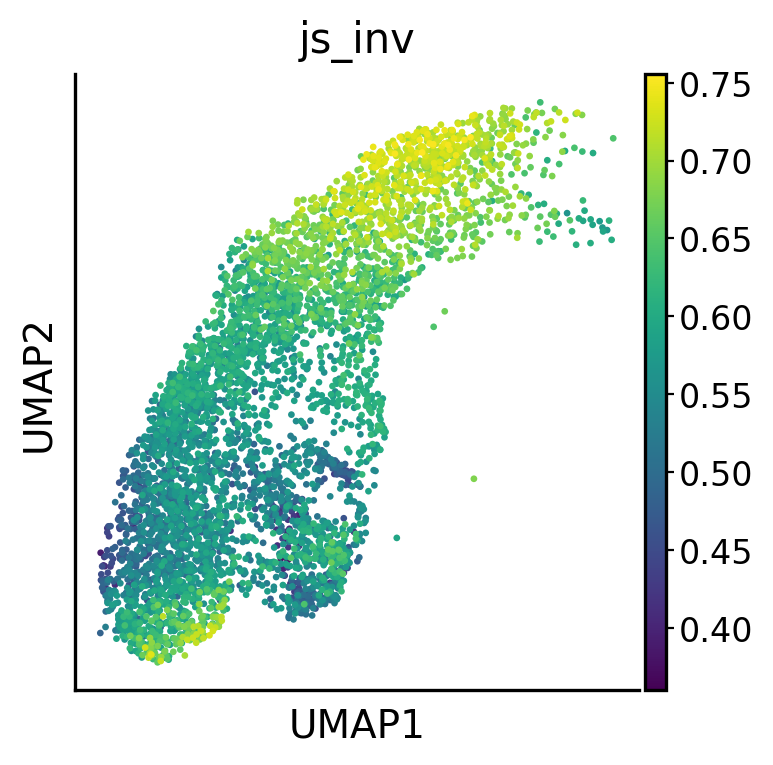

In [34]:
sc.pl.umap(adata_15, color="js_inv")

In [35]:
adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")

/tmp/ipykernel_1269495/2605882233.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")


,js_inv
cell_type_refined,
Delta,0.504758
Fev+ Alpha,0.523048
Fev+ Beta,0.536583
Alpha,0.542961
Fev+,0.564531
Epsilon,0.577622
Beta,0.584048
"Fev+ Delta,1",0.601459
"Fev+ Delta,0",0.603883
